# **APROXIMACIÓN 1. LSTM con Log Price y Rezagos**

In [ ]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Validamos base

df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2024,71332.0,69608.5,71367.5,69576.6,4245000.0,2.47
1,03/30/2024,69611.5,69872.3,70321.2,69564.9,2987000.0,-0.37
2,03/29/2024,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26
3,03/28/2024,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
4,03/27/2024,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
...,...,...,...,...,...,...,...
3008,01/05/2016,431.2,433.3,435.3,428.9,4503000.0,-0.49
3009,01/04/2016,433.3,430.7,435.3,428.6,5301000.0,0.61
3010,01/03/2016,430.7,433.7,434.1,423.1,5483000.0,-0.70
3011,01/02/2016,433.7,434.0,437.4,430.7,3357000.0,-0.06


In [ ]:
# Transformamos formato de 'Date'

df['Date']=pd.to_datetime(df['Date'])

In [ ]:
# Ponemos fecha como Index

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Validamos df

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-01,434.0,430.0,438.0,425.9,4697000.0,0.94
2016-01-02,433.7,434.0,437.4,430.7,3357000.0,-0.06
2016-01-03,430.7,433.7,434.1,423.1,5483000.0,-0.70
2016-01-04,433.3,430.7,435.3,428.6,5301000.0,0.61
2016-01-05,431.2,433.3,435.3,428.9,4503000.0,-0.49
...,...,...,...,...,...,...
2024-03-27,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
2024-03-28,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
2024-03-29,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26


In [ ]:
# Validamos Tipos de Datos

df.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

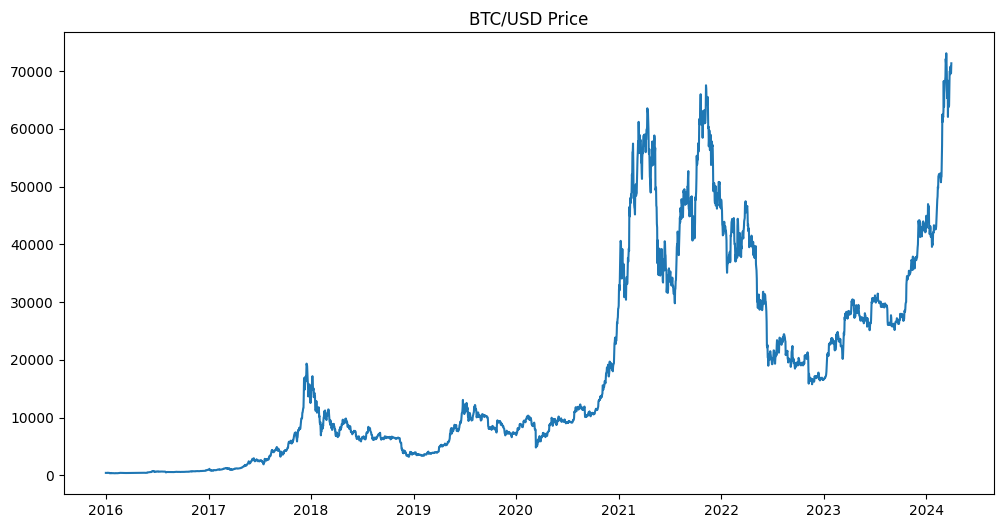

In [ ]:
# Graficamos Precio contra Tiempo

plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('BTC/USD Price')
plt.show()

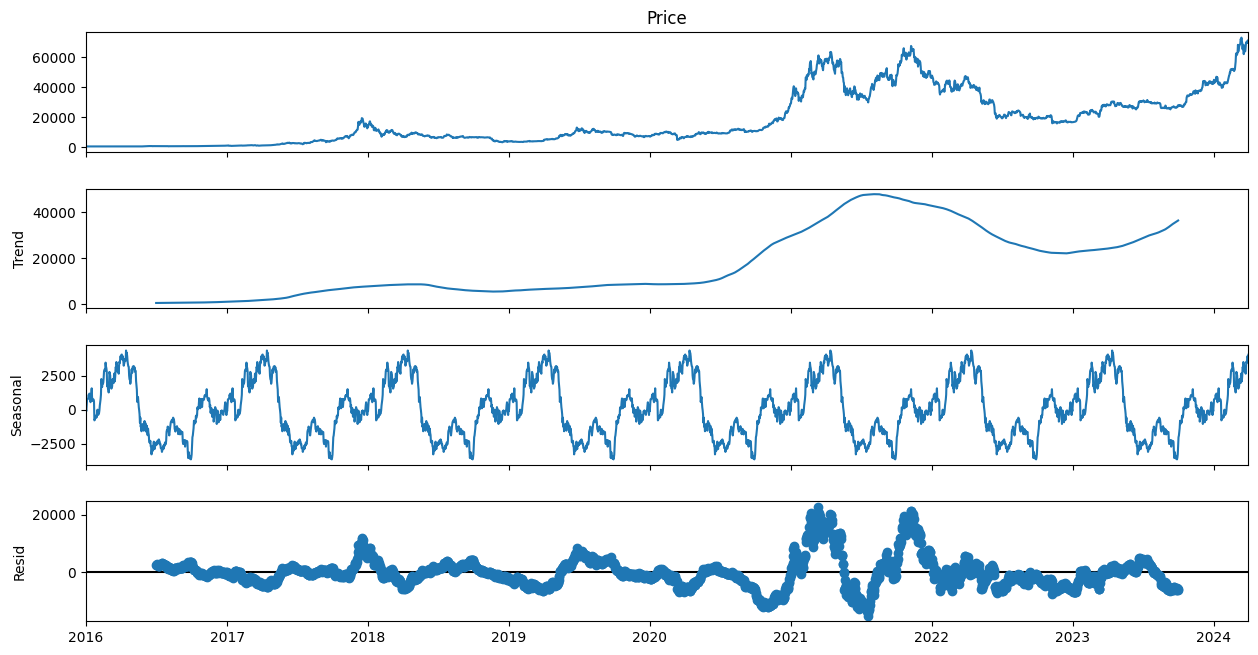

In [ ]:
# Descomponemos en patrones cíclicos

decomposition = seasonal_decompose(df['Price'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

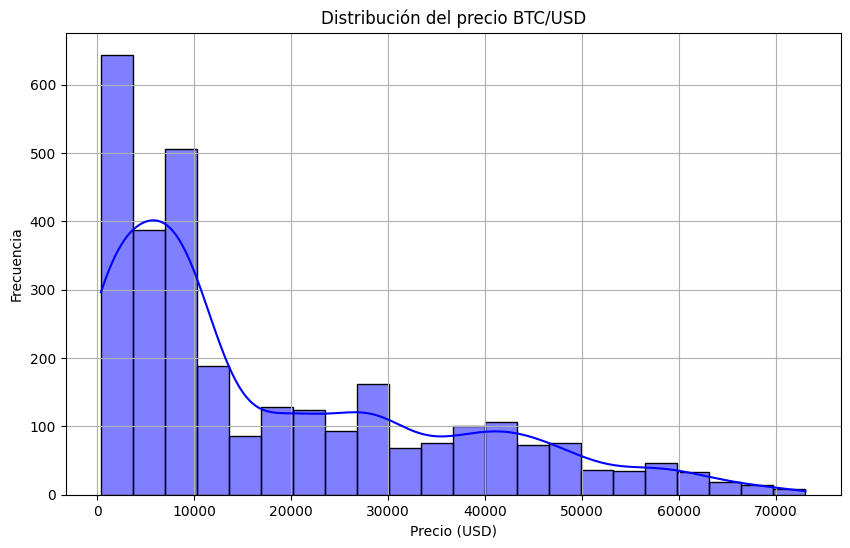

In [ ]:
# Graficamos Distribución de la Serie en Log BTC/USD

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='b')
plt.title('Distribución del precio BTC/USD')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price']=np.log(df['Price'])

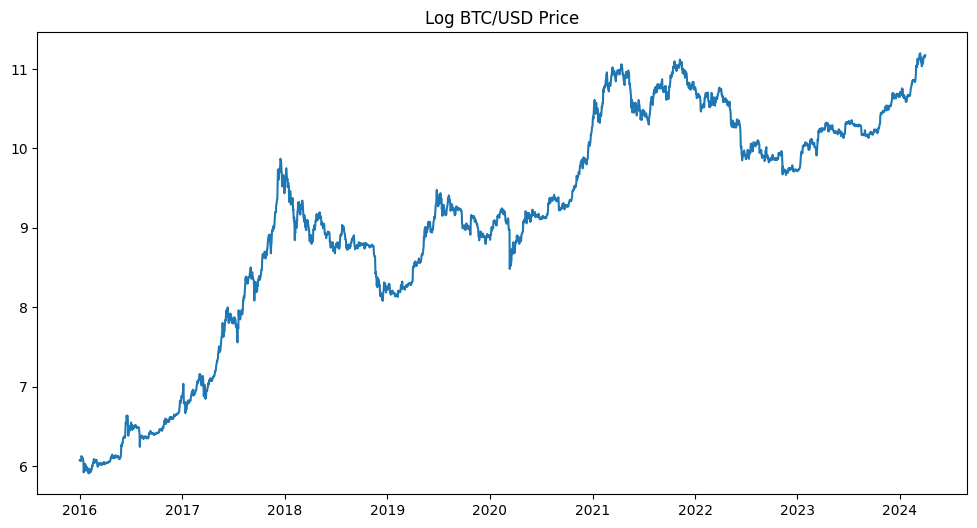

In [ ]:
# Graficamos serie transformada

plt.figure(figsize=(12, 6))
plt.plot(df['Log_Price'])
plt.title('Log BTC/USD Price')
plt.show()

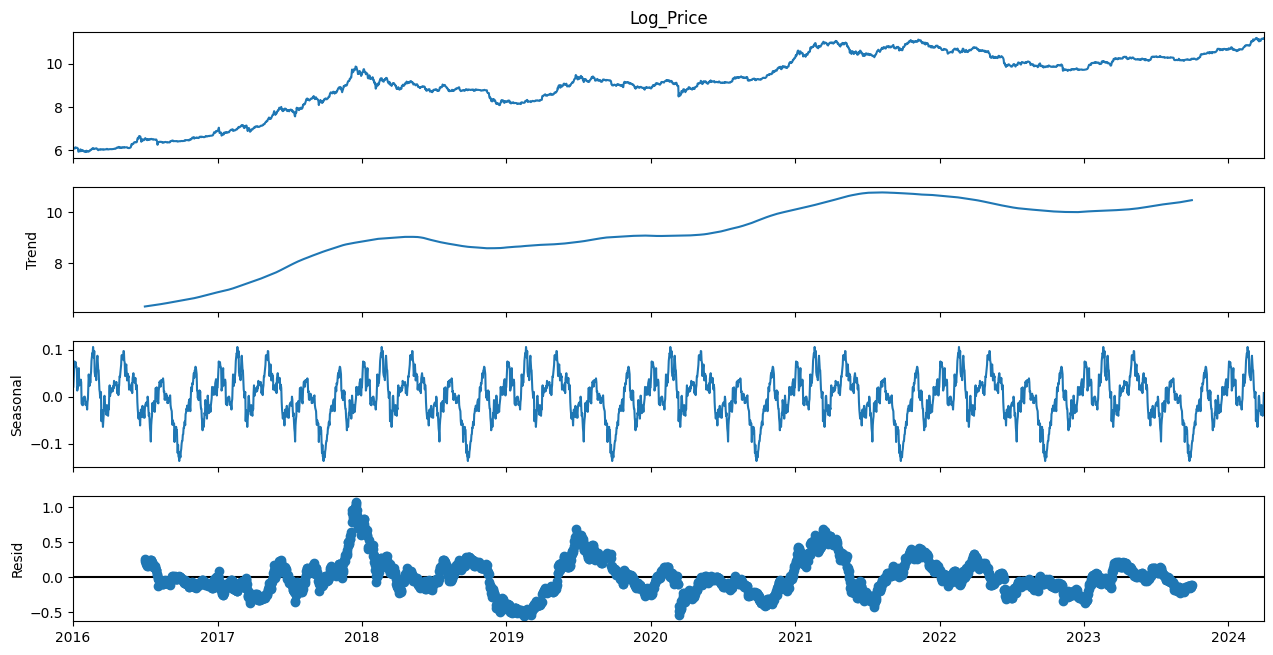

In [ ]:
# Desagregamos componentes

decomposition = seasonal_decompose(df['Log_Price'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4) # Incrementamos Lags
lagged_df.dropna(inplace=True)  # Quitamos NaN

In [ ]:
# Dividimos en entrenamiento y test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price','Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price','Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
# Validamos conjuntos sobre órden Cronológico

X_train

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,10.026240,10.035428,10.042754,10.054972


In [ ]:
X_test

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2022-08-08,23175.3,24234.1,23160.6,19794000.0,2.77,10.050842,10.040820,10.056561,10.026240
2022-08-09,23818.1,23912.0,22886.5,16962000.0,-2.81,10.078125,10.050842,10.040820,10.056561
2022-08-10,23150.3,24209.9,22714.7,24361000.0,3.53,10.049608,10.078125,10.050842,10.040820
2022-08-11,23963.3,24873.5,23864.0,28536000.0,-0.12,10.084262,10.049608,10.078125,10.050842
2022-08-12,23935.3,24440.8,23616.4,19496000.0,1.94,10.083110,10.084262,10.049608,10.078125
...,...,...,...,...,...,...,...,...,...
2024-03-27,69999.2,71670.8,68428.6,11288000.0,-0.80,11.156241,11.154706,11.115606,11.067229
2024-03-28,69449.4,71542.5,68956.9,7249000.0,1.90,11.148253,11.156241,11.154706,11.115606
2024-03-29,70766.7,70907.0,69090.9,5899000.0,-1.26,11.167079,11.148253,11.156241,11.154706


In [ ]:
# Escalamos Datos

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# Creamos Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Redimensionamos para LSTM

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [ ]:
# Establecemos Hiper-Parámetros Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Realizamos partición para serie de Tiempo y Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Generamos Grid Seach

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores resultados y puntaje

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

19/19 [==============================] - 1s 5ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 50, 'dropout_rate': 0.2}
Best score: 0.005904578413609051


In [ ]:
# Entrenamos mejor modelo sobre el conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo en conjunto test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 4ms/step
Test RMSE: 0.039236022966564685


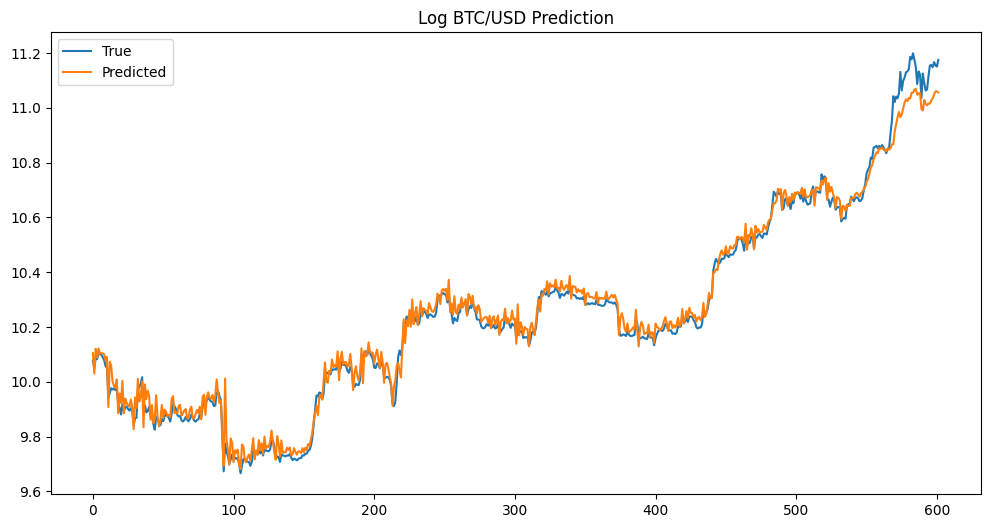

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

# **APROXIMACIÓN 2. LSTM con Log Price, rezagos y componentes cíclicos**

In [ ]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Ajustamos formato de 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Establecemos 'Date' como index y aseguramos órden cronológico

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

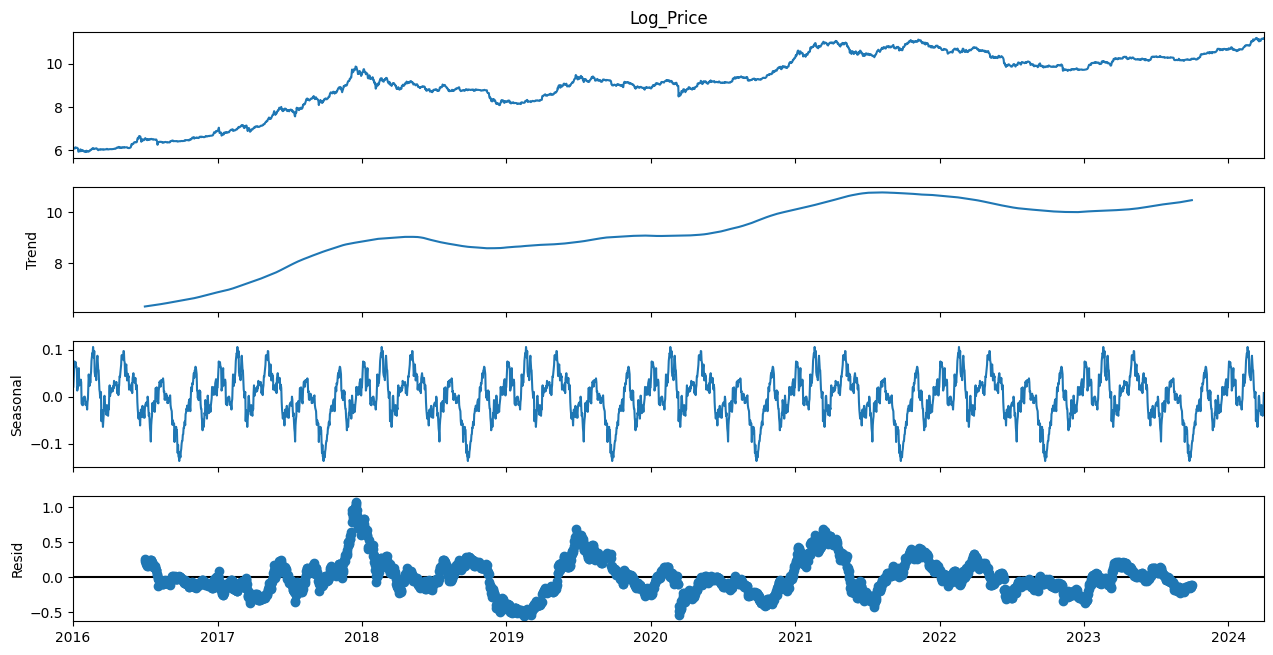

In [ ]:
# Descomponemos serie log para encontrar patrones cíclicos

decomposition = seasonal_decompose(df['Log_Price'], model='additive', period=365)
df['Seasonal'] = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

In [ ]:
# Creamos rezagos con componentes cíclicos

def create_lag_features(data, n_lags=30):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    lagged_data['Seasonal'] = data['Seasonal']  # Include the seasonal component
    return lagged_data

lagged_df = create_lag_features(df, n_lags=60) # Increased number of lags
lagged_df.dropna(inplace=True)  # Drop NaN values

In [ ]:
# Particionamos en train y test de forma cronológica

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
# Escalamos datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Función para crear Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Adaptamos dimensiones para LSTM

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [ ]:
# Establecemos Grid para Hiperparámetros

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Dividimos Serie para Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores parámetros y puntaje
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 1s 24ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 100, 'dropout_rate': 0.3}
Best score: 0.061814965521035624


In [ ]:
# Entrenamos mejor modelo sobre conjunto de entrenamiento total

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
# Evaluamos modelo en test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 25ms/step
Test RMSE: 0.2810810277179636


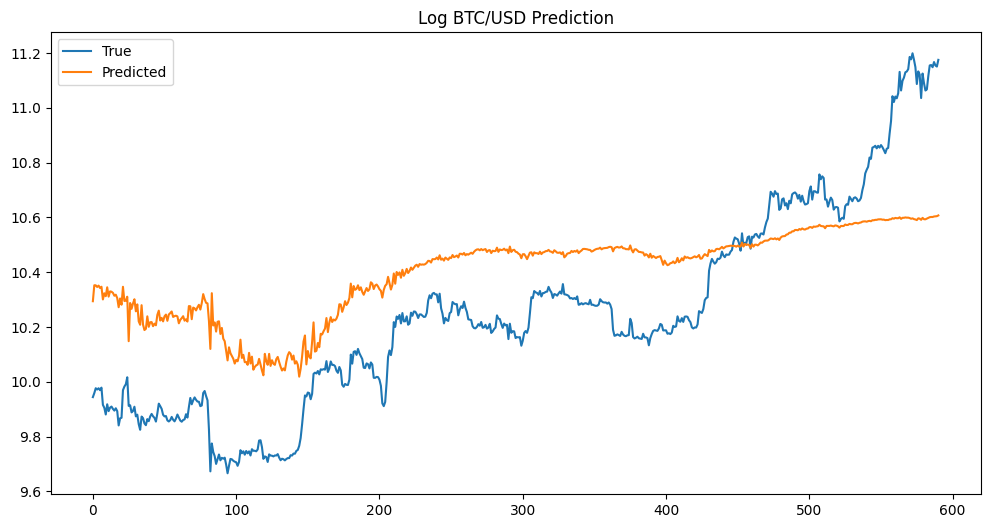

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

#**APROXIMACIÓN 3: Gated Recurrent Unit -GRU-**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Transformamos formato de 'Date'

df['Date'] = pd.to_datetime(df['Date'])

# Ponemos fecha como Index

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)  # Incrementamos Lags
lagged_df.dropna(inplace=True)  # Quitamos NaN

In [ ]:
# Dividimos Entrenamiento y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")

X_train length: 2407, y_train length: 2407
X_test length: 602, y_test length: 602


In [ ]:
# Aseguramos compatibilidad de dimensiones

if len(X_train) != len(y_train):
    raise ValueError("The lengths of X_train and y_train do not match!")

if len(X_test) != len(y_test):
    raise ValueError("The lengths of X_test and y_test do not match!")


In [ ]:
# Escalamos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Redimensionamos para GRU

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [ ]:
# Validamos dimensiones:

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9, 1), y_train shape: (2407,)
X_test_reshaped shape: (602, 9, 1), y_test shape: (602,)


In [ ]:
# Creamos Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos Hiper-Parámetros Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Realizamos partición para serie de Tiempo y Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Generamos Grid Seach

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        # Validamos dimensiones
                        print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
                        print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores resultados y puntaje
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

X_train_fold shape: (604, 9, 1), y_train_fold shape: (604,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 3ms/step
X_train_fold shape: (1205, 9, 1), y_train_fold shape: (1205,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 3ms/step
X_train_fold shape: (1806, 9, 1), y_train_fold shape: (1806,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 3ms/step
X_train_fold shape: (604, 9, 1), y_train_fold shape: (604,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 3ms/step
X_train_fold shape: (1205, 9, 1), y_train_fold shape: (1205,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 3ms/step
X_train_fold shape: (1806, 9, 1), y_train_fold shape: (1806,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [========================

In [ ]:
# Entrenamos mejor modelo sobre el conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
# Evaluamos modelo en conjunto test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 4ms/step
Test RMSE: 0.23733906842112354


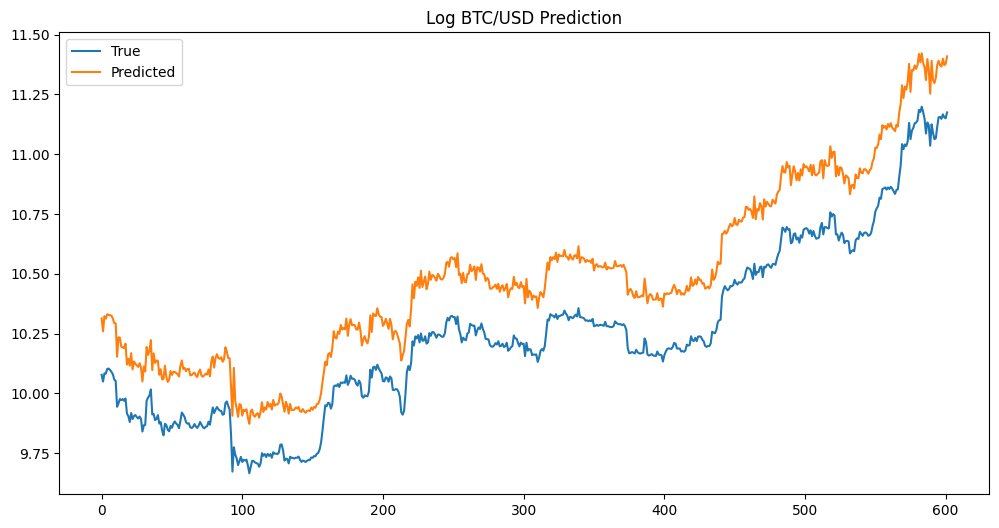

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

# **APROXIMACIÓN 4 RNN**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Transformamos formato 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Ponemos 'Date' como Index y organizamos cronológicamente

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Incorporamos Transformación Logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos Rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)
lagged_df.dropna(inplace=True)

In [ ]:
# Dividimos en Train y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

# Aseguramos compatibilidad de dimensiones

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
# Escalamos Datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Redimensionamos para RNN

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Validamos Dimensiones

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9, 1), y_train shape: (2407,)
X_test_reshaped shape: (602, 9, 1), y_test shape: (602,)


In [ ]:
# Creamos función para el modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos Hiperparámetros para el Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}


In [ ]:
# Establecemos Validación Cruzada para Serie de Tiempo

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos el Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        # Create and train model
                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Validate model
                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        # Track best parameters
                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores valores y Métrica

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 0s 3ms/step
Best parameters: {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam', 'units': 100, 'dropout_rate': 0.2}
Best score: 0.008618678236100092


In [ ]:
# Entrenamos mejor modelo con todo conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo en Test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 0s 3ms/step
Test RMSE: 0.1917212929178427


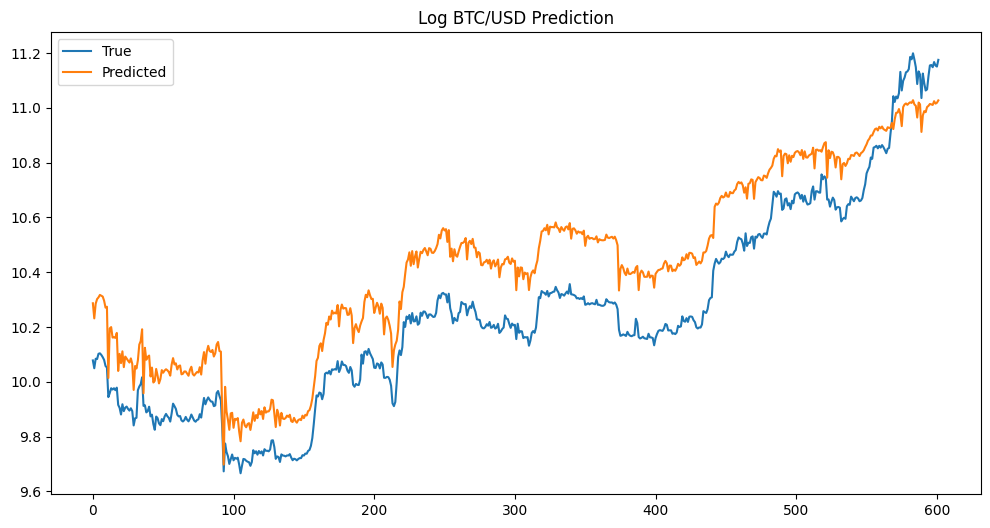

In [ ]:
# Graficamos predicciones y valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

# **APROXIMACIÓN 5 MLP**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
# Cargamos Base

df = pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')


In [ ]:
# Transformamos formato 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Establecemos 'Date' como Index y Ordenamos Cronológicamente

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)
lagged_df.dropna(inplace=True)

In [ ]:
# Dividimos entrenamiento y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
# Validamos dimensiones

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
# Escalamos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# En este caso no necesitamos transformación

X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

# Validamos Dimensiones

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9), y_train shape: (2407,)
X_test_reshaped shape: (602, 9), y_test shape: (602,)


In [ ]:
# Creamos función del modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(X_train_reshaped.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos hiperparámetros para grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}


In [ ]:
# Validación Cruzada para Serie de Tiempo

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]


                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)


                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)


                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores parámetros y métrica

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 0s 1ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 50, 'dropout_rate': 0.2}
Best score: 0.04068439917928832


In [ ]:
# Entrenamos mejor modelo sobre todo conjunto de Train

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo sobre test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 0s 1ms/step
Test RMSE: 0.1423058406453237


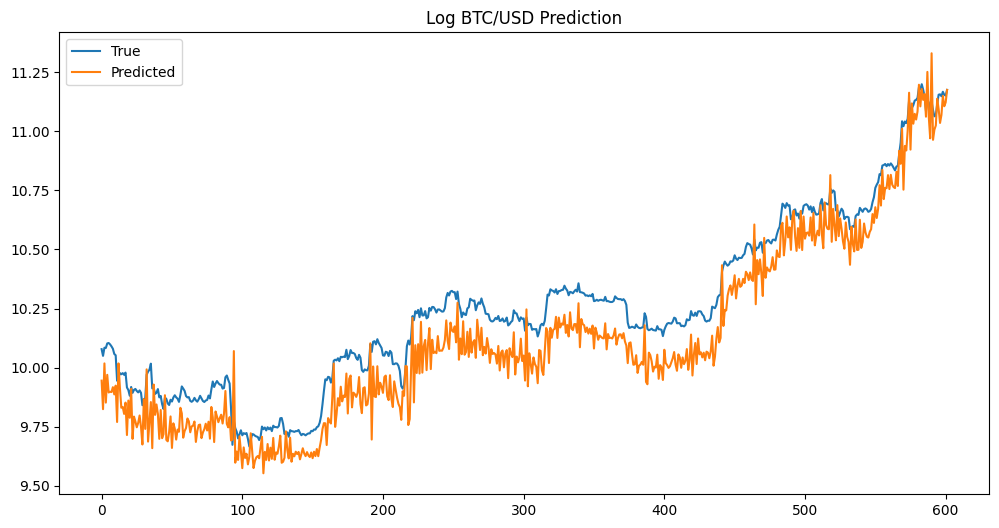

In [ ]:
# Graficamos predicciones y valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()